In [1]:
import numpy as np
import torch
from data_gen import *
from BP import *
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from DNN_BP import *

In [2]:
# Choose configuration for channel
Nt, Nr =  8, 32
batch = 500
Es = 10

SNR = np.arange(4,15,2)
noise_var = noise_variance(SNR, Es, Nt)
device = torch.device('cuda:0')

net = DNN_dBP_10(Nt,Nr,device)
file = 'DNN-dBP-8x32-10.pt'

net.load_state_dict(torch.load(file))

<All keys matched successfully>

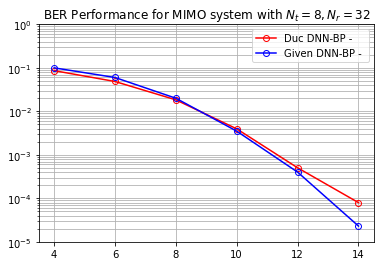

KeyboardInterrupt: 

In [3]:
Rx, Tx = 0.0, 0.3

num = 0
flag = 0
BER = np.zeros((6))
ER  = np.zeros((6))

s = torch.tensor([-3.0,-1.0,1.0,3.0], device=device).view(4)

# given_BER = np.array([1e-1, 5e-2, 2e-2, 4e-3, 4.5e-4, 1.1e-5]) # I.I.D
# given_BER = np.array([1e-1, 5e-2, 1.6e-2, 3e-3, 3e-4, 1.2e-5]) # Rx-Cor 
given_BER = np.array([1e-1, 6e-2, 2e-2, 3.5e-3, 4e-4, 2.3e-5]) # Tx-Cor 
# given_BER = np.array([1e-1, 5e-2, 1.6e-2, 3e-3, 5e-4, 7e-5]) # Rx-Tx-Cor 

while (True):
    num += 1
    for noise in noise_var:
        y, x, H = data_gen_16QAM(batch, Nt, Nr, noise, Rx, Tx, device)
        P = torch.ones(size=(batch, 2*Nr, 2*Nt, 4), device=device)*0.25
     
        _ , gamma = net( y, H, P, noise)
        
        x_p = s[torch.argmax(gamma, dim=3)]
        
        ER[flag%6] += torch.sum(torch.squeeze(x_p) != torch.squeeze(x.cuda()))
        BER[flag%6] = ER[flag%6]/(batch*4*Nt*(num))
        
        flag += 1        
    
    line1 = plt.plot(SNR, BER,c='red', ls='-', marker='o', mfc='none')
    line2 = plt.plot(SNR, given_BER,c='blue', ls='-', marker='o', mfc='none')
    plt.yscale('log')
    plt.title('BER Performance for MIMO system with $N_{t} = 8, N_{r} = 32$')
    plt.grid(True, which = 'both')
    plt.ylim(1e-5, 1e0)
    plt.legend(('Duc DNN-BP - ','Given DNN-BP - '))
    
    clear_output(wait = True)
    plt.pause(0.01)